In [1]:
import random
import torch
from torchvision import transforms, datasets
from torchvision.models import vgg16
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import os


manualSeed = 999 # Set random seed for reproducibility
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


# Hyperparameters

In [2]:
batch_size = 16
learning_rate = 0.001
num_epochs = 1

# Datasets

In [3]:
data_dir = r"C:\Users\yaoko\Downloads\archive\fruits-360-original-size\fruits-360-original-size"
TRAIN = "Training"
VAL = "Validation"
TEST = "Test"
data_transforms = {
    TRAIN: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    VAL: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
    TEST: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in [TRAIN, VAL, TEST]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
class_names = image_datasets[TRAIN].classes
n_classes = len(class_names)
print("Nb of classes :", len(class_names))

Loaded 6231 images under Training
Loaded 3114 images under Validation
Loaded 3110 images under Test
Nb of classes : 24


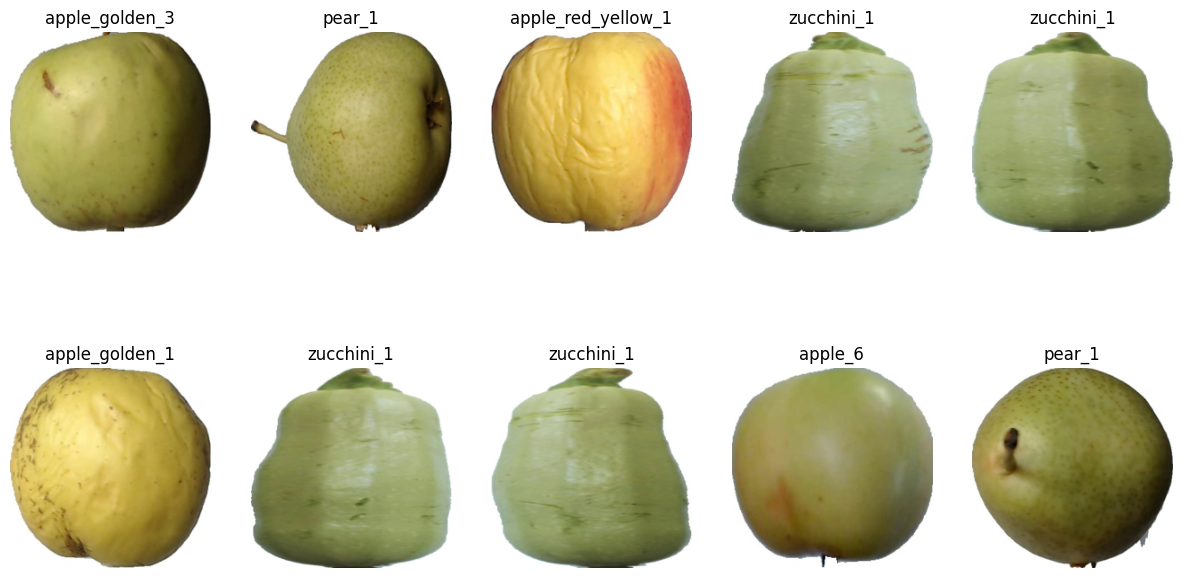

In [4]:
num_images_to_display = 10
dataset = image_datasets[TRAIN]
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ith_dataset in enumerate(
    np.random.randint(low=0, high=len(dataset), size=num_images_to_display)
):
    image, label = dataset[ith_dataset]
    axes[i // 5, i % 5].imshow(image.numpy().transpose((1, 2, 0)))
    axes[i // 5, i % 5].axis("off")
    axes[i // 5, i % 5].set_title(class_names[label])
plt.show()

# Model

In [5]:
model = vgg16(weights='DEFAULT')
# Freeze training for all layers
for param in model.parameters():
    param.require_grad = False
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, n_classes), 
    nn.LogSoftmax(dim=1)
)
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=24, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Boucle d'entraînement
train_losses = []
dataloader = dataloaders[TRAIN]
n_batch = len(dataloader)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print(f"Epoch {epoch+1}...")
    for batch_data in tqdm(dataloader, total=n_batch):
        images = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        # Réinitialiser les gradients
        optimizer.zero_grad()
        # Propagation avant
        predictions = model(images)
        # Calcul de la perte
        loss = criterion(predictions, labels)
        # Rétropropagation
        loss.backward()
        # Mise à jour des poids
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= n_batch
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {epoch_loss:.4f}")

Epoch 1...


  0%|          | 0/390 [00:21<?, ?it/s]


KeyboardInterrupt: 

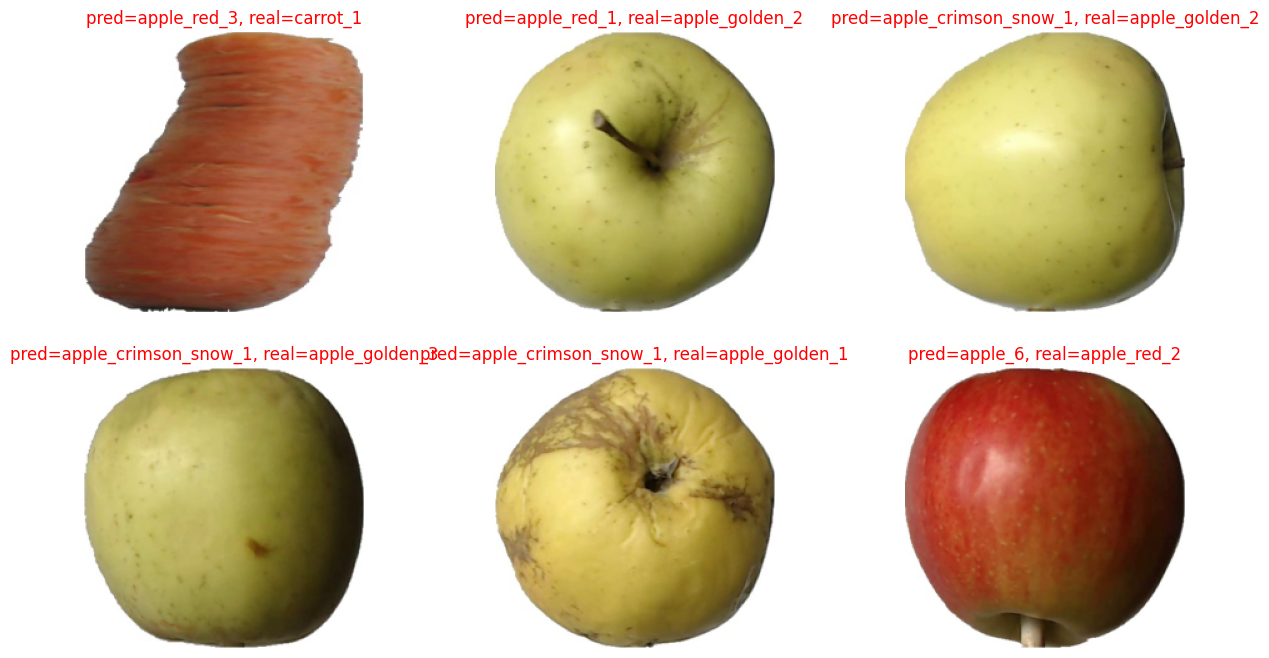

In [7]:
test_loader = dataloaders[TEST]
batch_idx, (images, labels) = next(enumerate(test_loader))
num_images_to_display = 10
dataset = image_datasets[TEST]
with torch.no_grad():
    output = model(images)  
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    predictions = output.argmax(dim=1)  
    for i, ax in enumerate(axes.flat):        
        ax.imshow(images[i].numpy().transpose((1, 2, 0)))
        prediction = predictions[i].item()
        target = labels[i].item()
        ax.axis("off")
        ax.set_title(f"pred={class_names[prediction]}, real={class_names[target]}", color='green' if prediction == target else 'red')
    plt.show()